In [1]:
pip install tensorflow opencv-python pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization  # Import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2  # Import l2 regularizer

In [5]:
df = pd.read_csv(r"C:\Users\USER\Documents\NITDA\Data science advanced\DSA project\ODIR\full_df.csv")
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [9]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

<Axes: xlabel='labels', ylabel='Patient Age'>

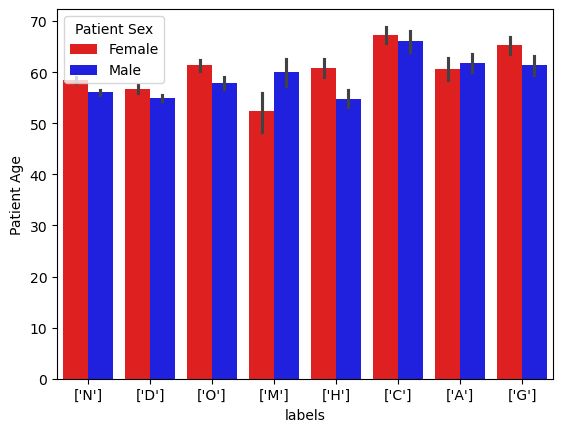

In [13]:
sns.barplot(data=df, x="labels", y="Patient Age", hue="Patient Sex", palette={"Male": "blue", "Female": "red"})

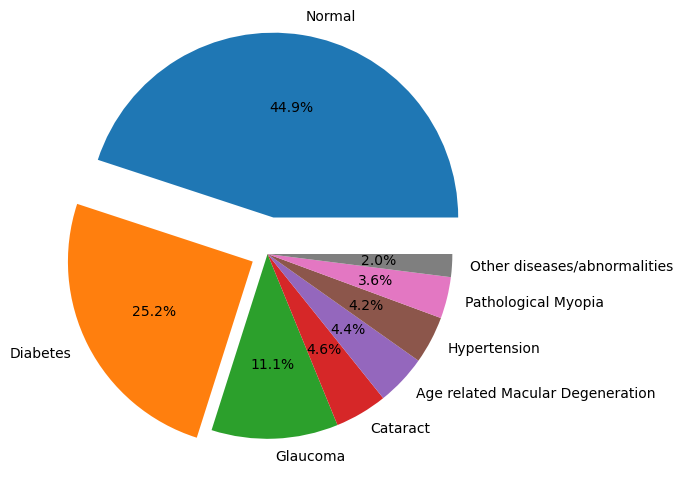

In [15]:
plt.figure(figsize=(6,6))
plt.pie(df['labels'].value_counts(), autopct="%0.1f%%",  # Fixed %0.1F to %0.1f
       labels=['Normal','Diabetes','Glaucoma','Cataract','Age related Macular Degeneration','Hypertension',
                'Pathological Myopia','Other diseases/abnormalities'],
       explode=[0.2, 0.09, 0, 0, 0, 0, 0, 0], shadow=False)  # Removed shadow
plt.show()

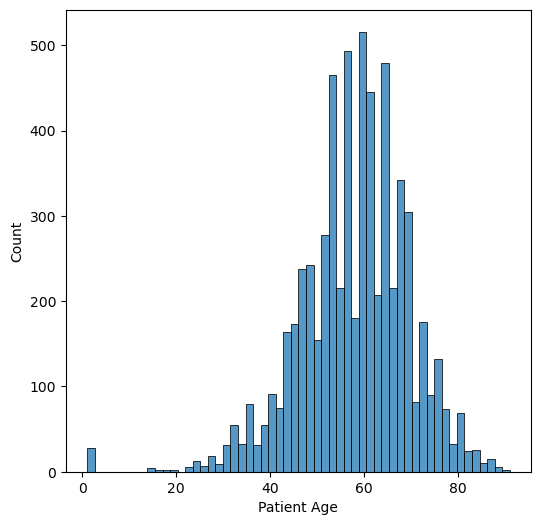

In [17]:
plt.figure(figsize=(6, 6))
sns.histplot(data=df, x="Patient Age")  # Removed unnecessary indentation
plt.show()

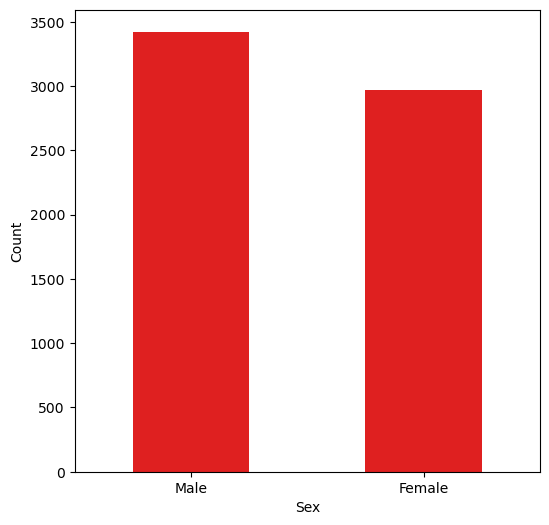

In [19]:
sex_counts = df['Patient Sex'].value_counts().reset_index()

sex_counts.columns = ['Sex', 'Count']

plt.figure(figsize=(6,6))
sns.barplot(x='Sex', y='Count', data=sex_counts, color='r', width=0.5)
plt.show()

In [21]:
print(df.columns)  # List all available column names

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


In [23]:
# Encode labels into numerical values
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])
df['labels'] = df['labels'].astype(str)

In [25]:
# Combine left and right fundus images
left_images = df[['Left-Fundus', 'labels']]
right_images = df[['Right-Fundus', 'labels']]

left_images.columns = ['image', 'target']
right_images.columns = ['image', 'target']

combined_df = pd.concat([left_images, right_images])
combined_df = combined_df.dropna(subset=['image'])

In [27]:
# Split into training and testing sets
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

In [29]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [31]:
# Validation data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=r"C:\Users\USER\Documents\NITDA\Data science advanced\DSA project\ODIR\ODIR-5K\ODIR-5K\Training Images",
    x_col='image',
    y_col='target',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r"C:\Users\USER\Documents\NITDA\Data science advanced\DSA project\ODIR\ODIR-5K\ODIR-5K\Training Images",
    x_col='image',
    y_col='target',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32
)

Found 10227 validated image filenames belonging to 8 classes.
Found 2557 validated image filenames belonging to 8 classes.


In [35]:
# Load ResNet50 with pre-trained weights (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers initially
base_model.trainable = False

In [37]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes for ocular diseases

In [39]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[LearningRateScheduler(lambda epoch, lr: lr * 0.1 if epoch % 5 == 0 else lr), ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')]
)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1463s 5s/step - accuracy: 0.1330 - loss: 23.0342 - precision: 0.1294 - recall: 0.0530 - val_accuracy: 0.4337 - val_loss: 19.7706 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1511s 5s/step - accuracy: 0.1439 - loss: 20.4734 - precision: 0.1456 - recall: 0.0592 - val_accuracy: 0.1600 - val_loss: 17.9396 - val_precision: 0.2182 - val_recall: 0.0047 - learning_rate: 1.0000e-05
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1526s 5s/step - accuracy: 0.1568 - loss: 18.3459 - precision: 0.1590 - recall: 0.0628 - val_accuracy: 0.1193 - val_loss: 16.3336 - val_precision: 0.1447 - val_recall: 0.0086 - learning_rate: 1.0000e-05
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1494s 5s/step - accuracy: 0.1631 - loss: 16.5892 - precision: 0.1752 - recall: 0.0676 - val_accuracy: 0.1807 - val_loss: 14.7758 - val_precision: 0.2473 - val_recall: 0.0176 - learning_rate: 1.0000e-05
Epoch 5/20
320/320 ━━━━━

In [52]:
# Evaluate on the test set
results = model.evaluate(val_generator)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.3623 - loss: 12.5916 - precision_2: 0.2110 - recall_2: 0.0166
Test Loss: 12.58687973022461, Test Accuracy: 0.37192022800445557


In [54]:
import gradio as gr

# Function to predict the class of an uploaded image
def predict_image(image):
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0) / 255.0
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)
    return encoder.inverse_transform(predicted_class)[0]

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(label="Upload Retinal Fundus Image"),
    outputs=gr.Textbox(label="Predicted Disease"),
    title="Ocular Disease Recognition",
    description="Upload a retinal fundus image to predict the disease."
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [56]:
# Original label mapping
label_mapping = {
    "N": "Normal",
    "D": "Diabetes",
    "G": "Glaucoma",
    "C": "Cataract",
    "A": "Age-related Macular Degeneration",
    "H": "Hypertension",
    "M": "Pathological Myopia",
    "O": "Other diseases/abnormalities"
}

# Reverse mapping for numerical labels to disease names
reverse_label_mapping = {i: label for i, label in enumerate(label_mapping.values())}

In [58]:
def predict_image(image):
    # Resize and preprocess the image
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict the class probabilities
    prediction = model.predict(image)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Map the predicted index to the disease name
    predicted_class_name = reverse_label_mapping[predicted_class_index]

    return predicted_class_name

In [60]:
import gradio as gr

# Define the Gradio interface
interface = gr.Interface(
    fn=predict_image,  # Use the updated prediction function
    inputs=gr.Image(label="Upload Retinal Fundus Image"),
    outputs=gr.Textbox(label="Predicted Disease"),
    title="Ocular Disease Recognition",
    description="Upload a retinal fundus image to predict the disease."
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [62]:
pip install streamlit